In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import hankel
from numpy.linalg import svd
import matplotlib.pyplot as plt

# CDS Spread Citi Data


In [2]:
df = pd.read_csv('citi_cds_monthly.csv', parse_dates=['Date'], index_col='Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 229 entries, 2025-01-10 to NaT
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1Y      192 non-null    float64
 1   2Y      171 non-null    float64
 2   3Y      194 non-null    float64
 3   4Y      170 non-null    float64
 4   6M      145 non-null    float64
 5   6M_1Y   145 non-null    float64
 6   2Y_6M   145 non-null    float64
 7   3Y_6M   145 non-null    float64
 8   4Y_6M   145 non-null    float64
 9   5Y      229 non-null    float64
 10  7Y      191 non-null    float64
 11  10Y     193 non-null    float64
 12  7Y_5Y   191 non-null    float64
 13  10Y_5Y  193 non-null    float64
dtypes: float64(14)
memory usage: 26.8 KB


In [3]:
maturity_columns = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '7Y', '10Y']
df = df[maturity_columns]
print("\nFirst 5 rows of CDS Spread data:") 
print(df.head())


First 5 rows of CDS Spread data:
                 6M       1Y       2Y       3Y       4Y       5Y       7Y  \
Date                                                                        
2025-01-10  18.9436  25.4459  31.8807  37.8275  45.9018  55.4789  69.6968   
2024-12-31  18.7973  24.6774  32.1823  37.8496  46.4850  56.0044  70.0602   
2024-11-29  18.5018  23.1773  30.1589  35.5736  43.7909  52.5652  67.0000   
2024-10-31  19.5169  23.7423  31.4756  38.2854  47.1183  57.0751  71.0415   
2024-09-30      NaN  24.9804  32.1611  38.8525  48.5508  59.1556  73.9324   

                10Y  
Date                 
2025-01-10  81.4822  
2024-12-31  81.4450  
2024-11-29  78.3753  
2024-10-31  81.8852  
2024-09-30  85.3695  


In [4]:
# count missing data in the column
print("\nMissing data in each column:")
print(df.isnull().sum())


Missing data in each column:
6M     84
1Y     37
2Y     58
3Y     35
4Y     59
5Y      0
7Y     38
10Y    36
dtype: int64


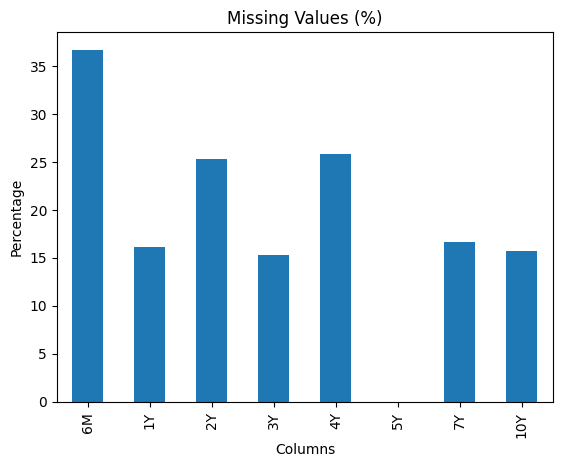

In [5]:
# plot the missing values as bar graph in %
missing_percent = df.isnull().sum() / len(df) * 100
missing_percent.plot(kind='bar')
plt.title('Missing Values (%)')
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.show()

# MSSA 

# Data Processing

We need to initially fill the missing values:- for this various methods can be used
    1. interpolate 
    2. extrapolation 
    3. forward fill
    4. backward fill

In [6]:
# Nominal filling nan using interpolation 
print(df.index.isnull().sum())  
df = df[~df.index.isnull()]
df_filled = df.interpolate(method='time')

# log transformation to stabilize variance and avoid -ve values
df_log = np.log(df_filled)


34


### Constructing Trajectory (Hankel) Matrix
hankel matrix is a (square/rect) n*m matrix in which each ascending skew-diagonal from left to right is constant. 
 The trajectory matrix is built by lagging the time series. Each row is a lagged version of the series.
 Formula: Y_i = [x_{i}, x_{i+1}, ..., x_{i+L-1}]


1:7 


[1 2 3 4
 2 3 4 5 
 3 4 5 6 
 4 5 6 7 ]



In [7]:
# function to create hankel matrix 
"""
    Constructing Hankel Matrix
    Args:
        series (np.array): Input time series cds spread for a specific maturity 
        window_size (int): L (lag)
    
    Returns:
        np.array: Hankel Matrix with lagged series
"""

# def hankel_matrix(series, window_size):
#     hankel = []
#     for i in range(window_size):
#         row = series[i:i+len(series)-window_size+1]
#         hankel.append(row)
#     return np.array(hankel)

def hankel_matrix(series, window_size):
    return np.array([series[i:i+len(series)-window_size+1] for i in range(window_size)])

In [38]:
window_size = min(10, len(df_log))  # selecting appropriate window size 
trajectory_matrices = [hankel_matrix(df_log[col].dropna().values, window_size) for col in df_log.columns]

In [26]:
# window_size = 1 # number of columns in hankel matrix
# #create a trajectory matrix for each series
# trajectory_matrics = [hankel_matrix(df_log[col].dropna().values, window_size) for col in df_log.columns]

In [40]:
min_cols = min(mat.shape[1] for mat in trajectory_matrices)
trajectory_matrices = [mat[:, :min_cols] for mat in trajectory_matrices]
trajectory_matrices

[array([[2.94146614, 2.93371324, 2.91786802, ..., 4.57728498, 4.57728498,
         4.57728498],
        [2.93371324, 2.91786802, 2.97128076, ..., 4.57728498, 4.57728498,
         4.57728498],
        [2.91786802, 2.97128076, 2.94711908, ..., 4.57728498, 4.57728498,
         4.57728498],
        ...,
        [2.98277367, 2.8480382 , 3.01876009, ..., 4.57728498, 4.57728498,
         4.57728498],
        [2.8480382 , 3.01876009, 3.05911544, ..., 4.57728498, 4.57728498,
         4.57728498],
        [3.01876009, 3.05911544, 3.1312941 , ..., 4.57728498, 4.57728498,
         4.57728498]]),
 array([[3.23655463, 3.20588785, 3.14317335, ..., 1.70478446, 1.49680658,
         1.41835004],
        [3.20588785, 3.14317335, 3.16725827, ..., 1.49680658, 1.41835004,
         1.7917928 ],
        [3.14317335, 3.16725827, 3.21809152, ..., 1.41835004, 1.7917928 ,
         1.7917928 ],
        ...,
        [3.14362197, 3.06309181, 3.2299028 , ..., 1.87183295, 1.7917928 ,
         1.68950524],
        [3.0

In [49]:
# Singular Value Decomposition (SVD) with exception handling
def safe_svd(matrix):
    try:
        return svd(matrix, full_matrices=False)
    except np.linalg.LinAlgError:
        print("Warning: SVD did not converge. Applying noise regularization.")
        matrix += np.random.normal(scale=1e-6, size=matrix.shape)
        return svd(matrix, full_matrices=False)

### Combining Trajectory Matrices
Stack all individual Hankel matrices vertically to form a combined trajectory matrix. Each Hankel matrix captures the lagged versions of the time series to reflect temporal structure. vstack() to vertically stack all the individual hankel matrices, which essentially contverts into multivariate domain, essentially combining all the maturities in on matrix


In [50]:
# combined hankel matrix 
# combined_trajectory_matrix = np.vstack(trajectory_matrics)
# combined_trajectory_matrix.shape

### Singular Value Decomposition
Now we can perform SVD on the combined trajectory matrix

        y = U.Sigma.V^T
    
here 

1. y = combined trajectory matrix 
2. U = left singular vectors 
3. sigma = diagonal matrix 
4. V^T = transpose od the matrix of right singualr vector 


In [51]:
# U, s, Vt = svd(combined_trajectory_matrix, full_matrices=False)

In [52]:
# def reverse_diagonal_average(matrix, window_size):
#     avg = []
#     for k in range(matrix.shape[1] + window_size - 1):
#         diag_elements = [matrix[i, k - i] for i in range(max(0, k - matrix.shape[1] + 1), min(window_size, k + 1))] #each diagonal represents a contribution from the overlapping windows 
#         avg.append(np.mean(diag_elements))
#     return np.array(avg)

# Iterative hole filling with anchoring

In [53]:
def iterative_mssa_filling(df, k_max=10, epsilon=1e-3, anchoring_type='multiplicative'):
    df_filled = df.copy()
    df_log = np.log(df_filled)
    
    missing_mask = df.isnull()
    k = 1
    prev_filled = df_log.fillna(method='ffill').fillna(method='bfill')
    
    while k <= k_max:
        trajectory_matrices = [hankel_matrix(prev_filled[col].dropna().values, window_size) for col in df_log.columns]
        min_cols = min(mat.shape[1] for mat in trajectory_matrices)
        trajectory_matrices = [mat[:, :min_cols] for mat in trajectory_matrices]
        combined_trajectory_matrix = np.vstack(trajectory_matrices)
        
        U, s, Vt = safe_svd(combined_trajectory_matrix)
        
        reconstructed_matrix = np.dot(U[:, :k], np.dot(np.diag(s[:k]), Vt[:k, :]))
        reconstructed_series = [np.mean(reconstructed_matrix[i*window_size:(i+1)*window_size], axis=0) for i in range(len(df_log.columns))]
        df_reconstructed = pd.DataFrame(np.exp(reconstructed_series).T, columns=df_log.columns, index=df_log.index[:len(reconstructed_series[0])])
        
        if anchoring_type == 'additive':
            anchor_shift = (df_filled - df_reconstructed).mean()
            df_reconstructed += anchor_shift
        elif anchoring_type == 'multiplicative':
            anchor_scale = (df_filled / df_reconstructed).mean()
            df_reconstructed *= anchor_scale
        
        new_filled = df_filled.copy()
        new_filled[missing_mask] = df_reconstructed[missing_mask]
        
        error = np.linalg.norm(new_filled - prev_filled, ord=1)
        if error < epsilon:
            break
        prev_filled = new_filled.copy()
        k += 1
    
    return new_filled

In [54]:
# apply
df_final = iterative_mssa_filling(df)

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/var/folders/_v/vfbxc80973l9zq3s4w559dzm0000gn/T/ipykernel_89958/2141105038.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prev_filled = df_log.fillna(method='ffill').fillna(method='bfill')
/var/folders/_v/vfbxc80973l9zq3s4w559dzm0000gn/T/ipykernel_89958/2141105038.py:19: RuntimeWarning: overflow encountered in exp
  df_reconstructed = pd.DataFrame(np.exp(reconstructed_series).T, columns=df_log.columns, index=df_log.index[:len(reconstructed_series[0])])


LinAlgError: SVD did not converge

#### Partital Reconstruction using the top singular values

We will reconstruct the data using the top k singular values to capture the main structure of the data. 

 here U: captures the row patterns 
 sigma: holds singualr values, which represent how important each pattern is 
 v^T: Captures the column patterns 

In [11]:
k = 5  # top 5 singular values 
reconstructed_matrix = np.dot(U[:, :k], np.dot(np.diag(s[:k]), Vt[:k, :])) 

In [12]:
# averaging the diagonal values for all the overalapping windows
def reverse_diagonal_average(matrix, window_size):
    avg = []
    for k in range(matrix.shape[1] + window_size - 1):
        diag_elements = [matrix[i, k - i] for i in range(max(0, k - matrix.shape[1] + 1), min(window_size, k + 1))] #each diagonal represents a contribution from the overlapping windows 
        avg.append(np.mean(diag_elements))
    return np.array(avg)

In [13]:
reconstructed_series = [reverse_diagonal_average(reconstructed_matrix[i*window_size:(i+1)*window_size], window_size) 
                        for i in range(len(df_log.columns))]


#### Inverse the log-transform 

In [14]:
df_reconstructed = pd.DataFrame(np.exp(reconstructed_series).T, 
                                 columns=df_log.columns, 
                                 index=df_log.index[:len(reconstructed_series[0])])

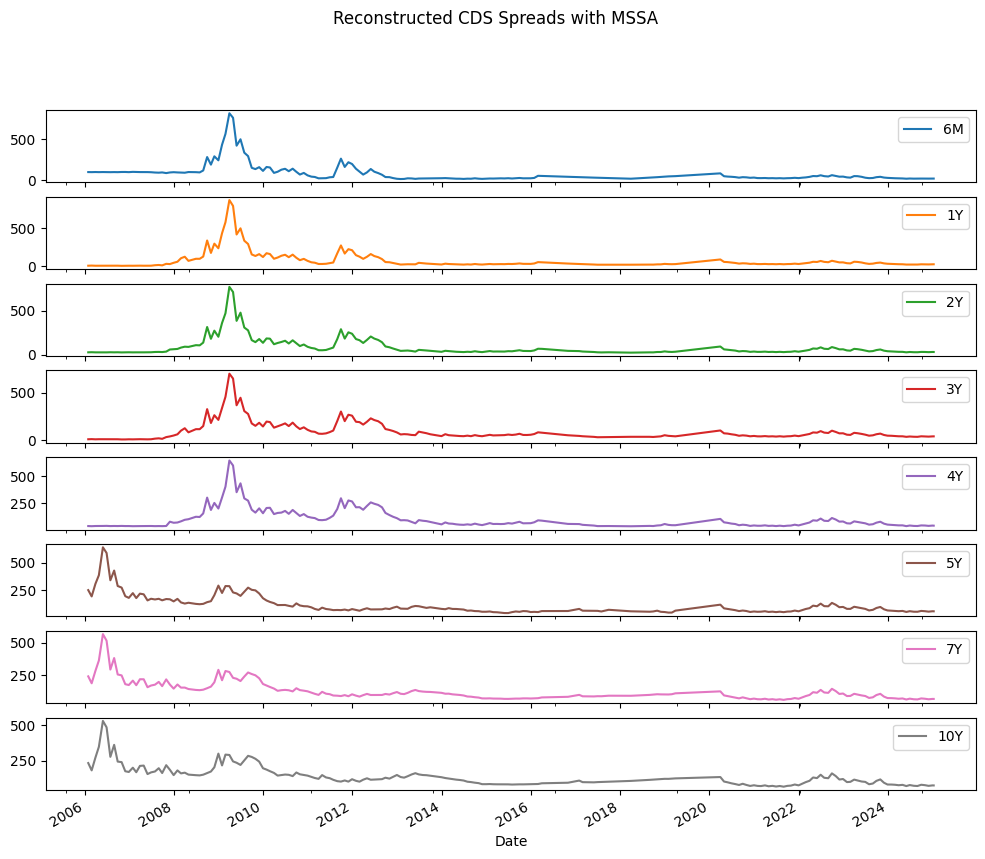

In [15]:
df_reconstructed.plot(subplots=True, figsize=(12, 10), title="Reconstructed CDS Spreads with MSSA")
plt.show()


In [16]:
df_final = df.copy()
for col in df_final.columns:
    df_final[col].fillna(df_reconstructed[col], inplace=True)

/var/folders/_v/vfbxc80973l9zq3s4w559dzm0000gn/T/ipykernel_89958/1017024098.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final[col].fillna(df_reconstructed[col], inplace=True)


In [17]:
print(df.index.equals(df_final.index))  # Should return True


True


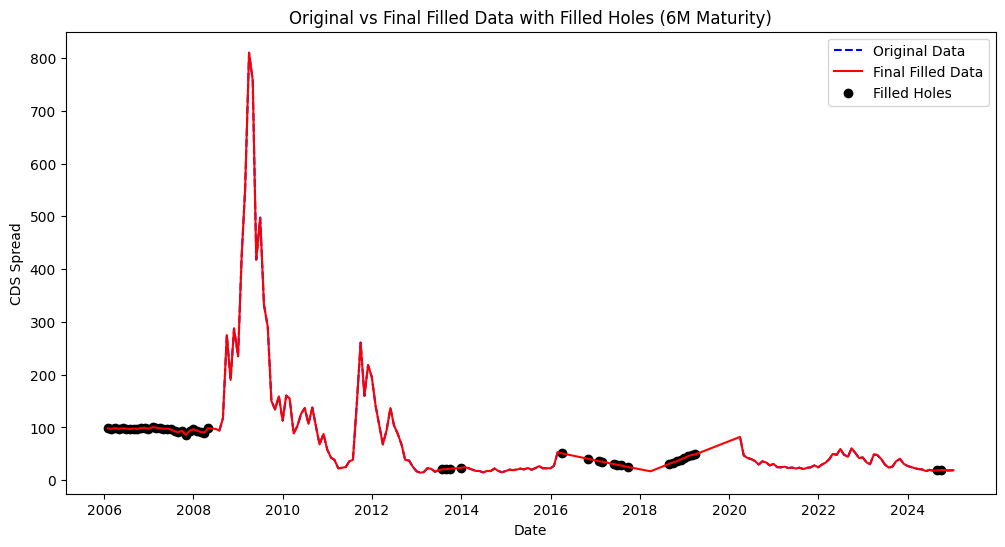

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['6M'], label='Original Data', color='blue', linestyle='--')
plt.plot(df_final.index, df_final['6M'], label='Final Filled Data', color='red')
missing_indices = df[df['6M'].isnull()].index
plt.scatter(missing_indices, df_final.loc[missing_indices, '6M'], color='black', label='Filled Holes', marker='o')
plt.title('Original vs Final Filled Data with Filled Holes (6M Maturity)')
plt.xlabel('Date')
plt.ylabel('CDS Spread')
plt.legend()
plt.show()

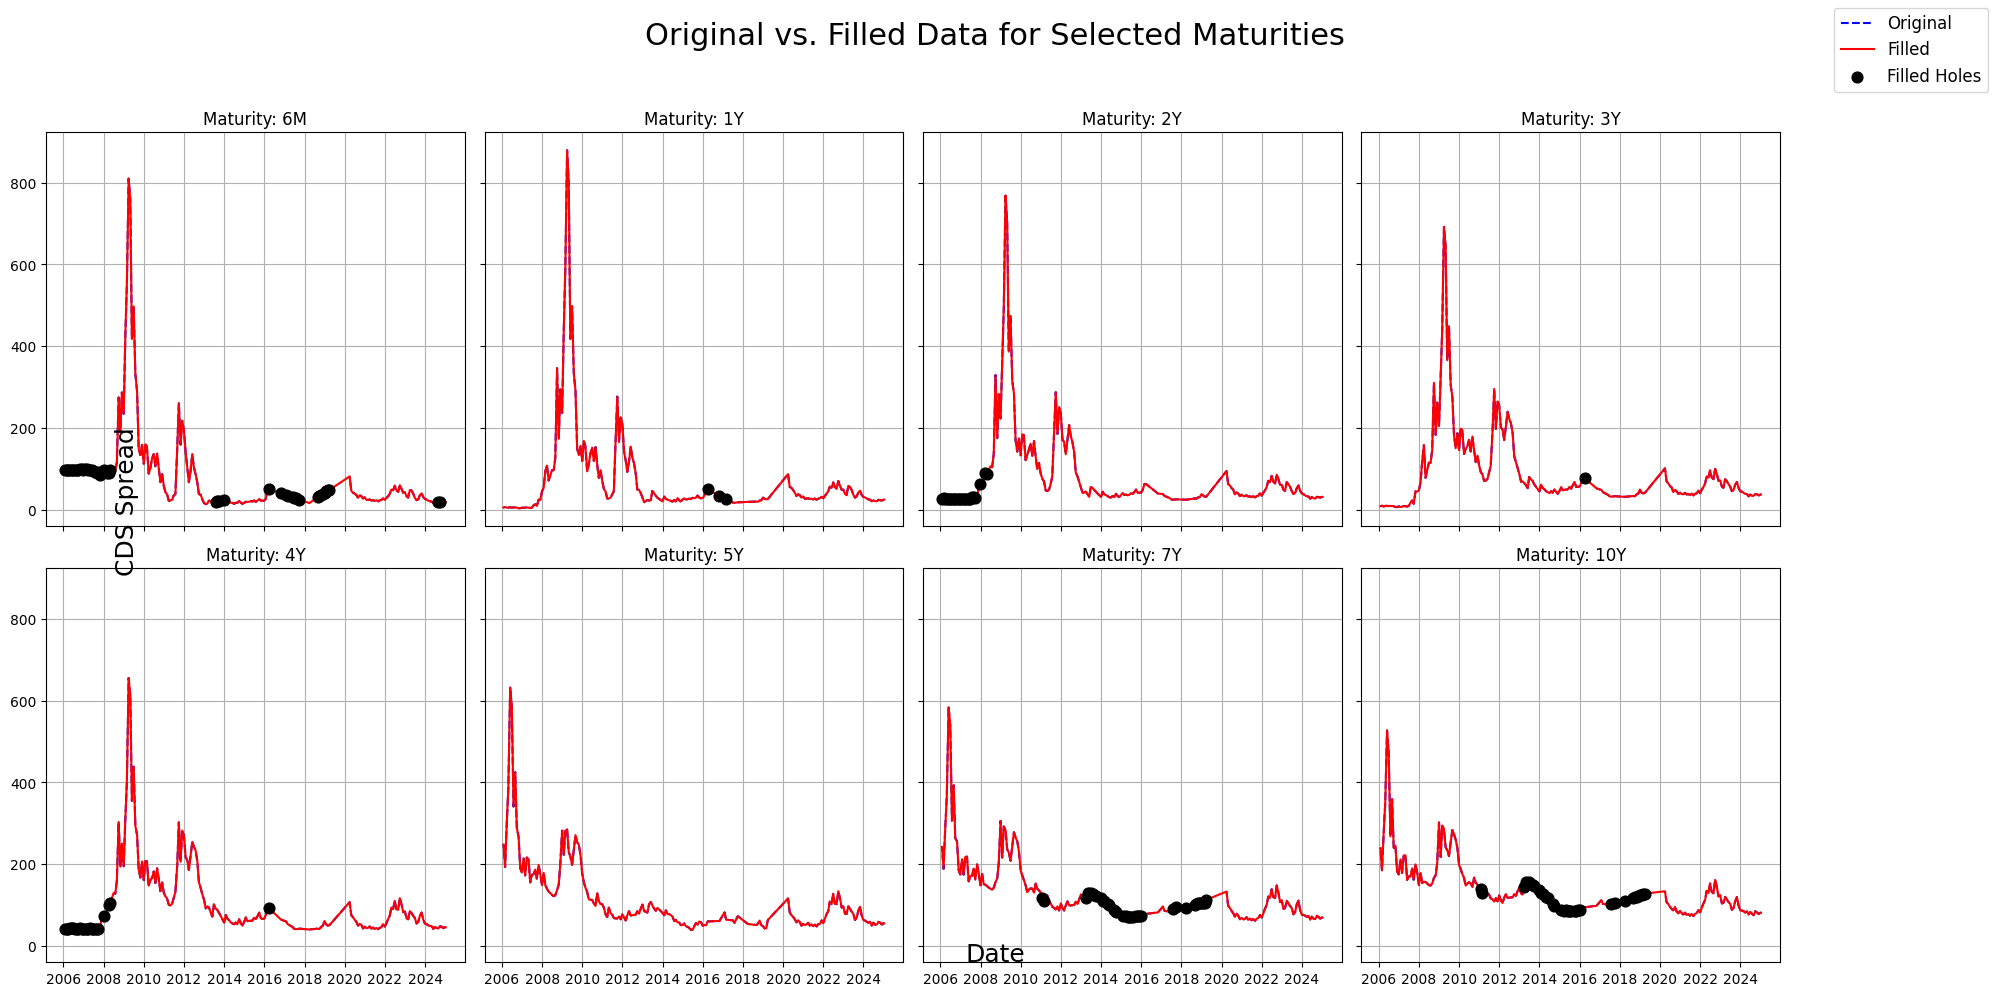

In [19]:
selected_maturities = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '7Y', '10Y']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()  

for ax, col in zip(axes, selected_maturities):
    ax.plot(df.index, df[col],
            linestyle='--', color='blue', label='Original')
    
    ax.plot(df_final.index, df_final[col],
            linestyle='-', color='red', label='Filled')
    missing_indices = df[df[col].isnull()].index
    ax.scatter(missing_indices, df_final.loc[missing_indices, col],
               color='black', marker='o', s=60, zorder=3, label='Filled Holes')
    
    ax.set_title(f'Maturity: {col}')
    ax.grid(True)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize='large')
fig.suptitle("Original vs. Filled Data for Selected Maturities", fontsize=22, y=0.98)
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=18)
fig.text(0.06, 0.5, 'CDS Spread', va='center', rotation='vertical', fontsize=18)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

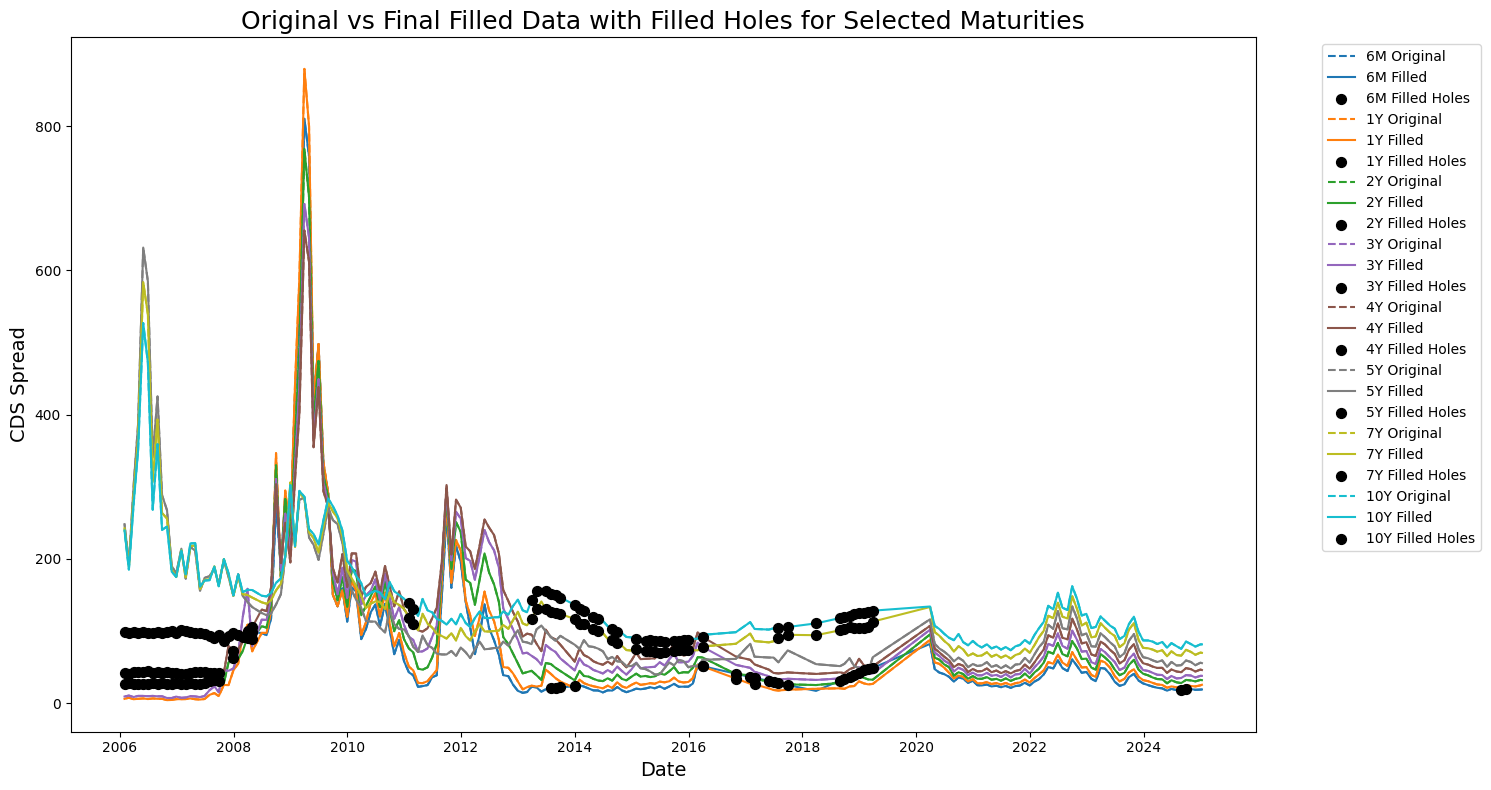

In [20]:
import matplotlib.cm as cm

selected_maturities = ['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '7Y', '10Y']
plt.figure(figsize=(15, 8))
colors = cm.tab10(np.linspace(0, 1, len(selected_maturities)))

for i, col in enumerate(selected_maturities):
    color = colors[i]
    plt.plot(df.index, df[col], linestyle='--', color=color, label=f'{col} Original')
    plt.plot(df_final.index, df_final[col], linestyle='-', color=color, label=f'{col} Filled')
    missing_indices = df[df[col].isnull()].index
    plt.scatter(missing_indices, df_final.loc[missing_indices, col], color='black', marker='o', s=50, zorder=3, label=f'{col} Filled Holes')

handles, labels = plt.gca().get_legend_handles_labels()
unique = {}
for handle, label in zip(handles, labels):
    if label not in unique:
        unique[label] = handle

plt.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='medium')
plt.title('Original vs Final Filled Data with Filled Holes for Selected Maturities', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('CDS Spread', fontsize=14)
plt.tight_layout()
plt.show()

# Aditive anchoring 
# mutliplicative anchoring 

Input
    - original_series 
    - reconstructed_series
    - achoring type (additive or multiplicative)
observed data:
    
CALCULATE ANCHORING FACTOR:
    
    IF anchoring_type == 'additive':
        - Compute the mean difference between observed and reconstructed values:
          anchor_shift = MEAN(observed_original - observed_reconstructed)
          
    ELSE IF anchoring_type == 'multiplicative':
        - Compute the scaling factor as the ratio of observed to reconstructed values:
          anchor_scale = MEAN(observed_original / observed_reconstructed)

APPLY ANCHORING TO RECONSTRUCTED SERIES:

    FOR each time point in reconstructed_series:
        IF anchoring_type == 'additive':
            anchored_series[time_point] = reconstructed_series[time_point] + anchor_shift
            
        ELSE IF anchoring_type == 'multiplicative':
            anchored_series[time_point] = reconstructed_series[time_point] * anchor_scale


# Iterative hole filling using a convergence criterion based on L1 and L2 norm
- start with k=1 
- comapare using L1 and L2 norm
- id the norm is greater than the epsilon, increse k and repeat 
- stop when norm < epsilon